Propozycja architektury (v2) — zmodernizowany CNN:

Blokami Residual (jak w ResNet, ale uproszczone),

BatchNorm + Dropout,

GlobalAvgPooling zamiast dużych FC warstw,

Klasyczną CrossEntropyLoss,

Optymalizatorem AdamW,

Schedulerem ReduceLROnPlateau,

EarlyStopping na bazie val_loss lub val_acc.



Kod (część 1): model + dane + transformacje

In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

# === Transforms ===
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2770, 0.2691, 0.2821)),
])

transform_test = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2770, 0.2691, 0.2821)),
])

# === Ścieżka do danych Tiny ImageNet ===
base_dir = '../tiny-imagenet-200'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')      
test_dir = os.path.join(base_dir, 'test')     

# === Datasety ===
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(root=os.path.join(val_dir, 'images'), transform=transform_test)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)

# === Loadery ===
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

print("✅ Dane zostały poprawnie przygotowane.")


✅ Dane zostały poprawnie przygotowane.


Kod (część 2): model z residualami i GAP

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.same_shape = in_channels == out_channels and stride == 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Sequential()
        if not self.same_shape:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.skip(x)
        return F.relu(out)

class MyTinyImageNetModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self._make_layer(64, 128, stride=2)
        self.layer2 = self._make_layer(128, 256, stride=2)
        self.layer3 = self._make_layer(256, 512, stride=2)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, 200)

    def _make_layer(self, in_channels, out_channels, stride):
        return nn.Sequential(
            ResidualBlock(in_channels, out_channels, stride),
            ResidualBlock(out_channels, out_channels, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


Część 4: trenowanie z early stoppingiem + zapisywanie statystyk

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Model, loss, optimizer, scheduler ===
model = MyTinyImageNetModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# === Early Stopping ===
early_stopping_patience = 8
best_val_loss = float('inf')
epochs_without_improvement = 0

# === Statystyki do wykresów ===
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

save_path = "best_model.pth"
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, targets in loop:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # === Walidacja ===
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            val_total += targets.size(0)
            val_correct += predicted.eq(targets).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"[{epoch+1}] Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}")

    scheduler.step(val_loss)

    # === Early stopping + zapis najlepszego modelu ===
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), save_path)
        print("✔️ Model saved.")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print("⛔ Early stopping triggered.")
            break

# === Załaduj najlepszy model
model.load_state_dict(torch.load(save_path))


Epoch 1/50: 100%|██████████| 1563/1563 [03:22<00:00,  7.73it/s]


[1] Train Loss: 4.7396, Val Loss: 4.2815, Train Acc: 0.0515, Val Acc: 0.0887
✔️ Model saved.


Epoch 2/50: 100%|██████████| 1563/1563 [03:16<00:00,  7.95it/s]


[2] Train Loss: 4.1426, Val Loss: 3.7308, Train Acc: 0.1206, Val Acc: 0.1648
✔️ Model saved.


Epoch 3/50:  10%|▉         | 151/1563 [00:33<05:13,  4.50it/s]


KeyboardInterrupt: 

Część 5: Wykresy loss/accuracy

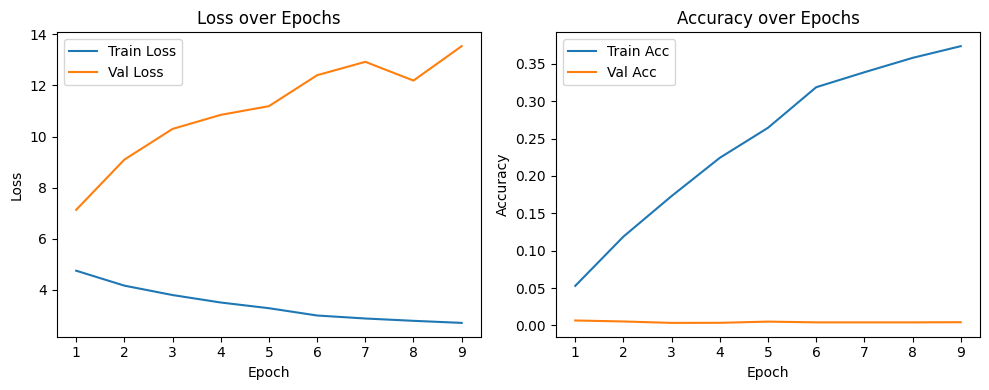

In [5]:
# === Wykresy
epochs = np.arange(1, len(train_losses) + 1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.savefig("training_curves.png")
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === Załaduj model i wagę ===
model = MyTinyImageNetModel().to(device)
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# === Statystyki klasyfikacji ===
print("📊 Raport klasyfikacji:")
print(classification_report(all_targets, all_preds, digits=4))

# === Macierz pomyłek (opcjonalnie z ograniczeniem do 10 klas) ===
cm = confusion_matrix(all_targets, all_preds)
class_names = test_dataset.classes

# Jeśli chcesz ograniczyć np. do 10 klas dla czytelności:
# cm = cm[:10, :10]
# class_names = class_names[:10]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
